In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import root_mean_squared_error



In [2]:
def fit_micropipeta(df,limx=None,limy=None):

    df_copy = df.copy()

    df_copy['Peso água(g)']=df_copy['Peso com líquido(g)']-df_copy['Peso(g)']
    passos = df_copy['Passos']
    peso_agua =df_copy['Peso água(g)']
   

    densidade_agua = 0.997  # g/mL
    volume_agua = (peso_agua / densidade_agua) * 1000  # μL
    df_copy['Volume experimental (µL)'] = (df_copy['Peso água(g)'] / densidade_agua) * 1000

    passos_unicos = np.unique(passos)
    volumes_media = np.array([np.mean(volume_agua[passos == p]) for p in passos_unicos])
    volumes_std = np.array([np.std(volume_agua[passos == p]) for p in passos_unicos])

    slope, intercept, r_value, p_value, std_err = linregress(passos_unicos, volumes_media)
    print(f"y = {slope:.5f}x + {intercept:.5f} (μL)")
    print(f"R² = {r_value**2:.5f}\n")

    volumes_fit = slope * passos_unicos + intercept

    rmse = root_mean_squared_error(volumes_media,volumes_fit)
    print(f"RMSE = {rmse:.5f}")

    plt.figure(figsize=(8,5))
    plt.errorbar(passos_unicos, volumes_media, yerr=volumes_std, fmt='o', capsize=5, ecolor='red', label='Média ± desvio padrão')
    plt.plot(passos_unicos, volumes_fit, 'b--', label=f'Fit Linear: y={slope:.5f}x+{intercept:.5f} μL')
    plt.xlabel("Passos")
    plt.ylabel("Volume de água (μL)")
    plt.title("Volume de água vs Passos com Fit Linear")
    plt.legend()
    plt.grid(True)
    if not(limx==None):
        plt.xlim(limx)
    
    if not(limy==None):
        plt.ylim(limy)

    plt.show()

    return df_copy



def validar_micropipeta(df_teste, limx=None, limy=None):
    df_copy = df_teste.copy()

    densidade_agua = 0.997  # g/mL
    df_copy['Peso água(g)'] = df_copy['Peso com líquido(g)'] - df_copy['Peso(g)']
    df_copy['Volume experimental (µL)'] = (df_copy['Peso água(g)'] / densidade_agua) * 1000  # μL

    # Cálculo dos erros
    df_copy['Erro absoluto (µL)'] = df_copy['Volume experimental (µL)'] - df_copy['Valor teórico']
    df_copy['Erro relativo (%)'] = (df_copy['Erro absoluto (µL)'] / df_copy['Valor teórico']) * 100

    # Estatísticas agrupadas
    resumo = df_copy.groupby('Valor teórico')[['Volume experimental (µL)', 'Erro absoluto (µL)', 'Erro relativo (%)']].agg(['mean', 'std'])

    # Gráfico
    fig, ax = plt.subplots(figsize=(8,5))
    ax.errorbar(
        resumo.index,
        resumo['Volume experimental (µL)']['mean'],
        yerr=resumo['Volume experimental (µL)']['std'],
        fmt='o',
        capsize=5,
        ecolor='red',
        label='Experimental (média ± desvio padrão)'
    )
    ax.plot(resumo.index, resumo.index, 'b--', label='Ideal: y = x')

    ax.set_xlabel('Volume teórico (µL)')
    ax.set_ylabel('Volume medido (µL)')
    ax.set_title('Validação Experimental da Micropipeta')
    ax.legend()
    ax.grid(True)

    # 🔧 Forçar exibição numérica normal (sem notação científica)
    ax.ticklabel_format(style='plain', axis='y', useOffset=False)
    ax.ticklabel_format(style='plain', axis='x', useOffset=False)
    plt.tick_params(axis='both', which='major', labelsize=10)

    # 🔧 Alternativamente, formatar os rótulos manualmente (garantia extra)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.get_xaxis().get_major_formatter().set_scientific(False)

    if limx is not None:
        ax.set_xlim(limx)
    if limy is not None:
        ax.set_ylim(limy)

    plt.show()

    print("\nResumo estatístico por volume teórico:")
    print(resumo)

    return df_copy

In [3]:
tentativas = [10,32.3,32.4,32.6,50,75,89.6,100,125,150,200,250,275,290.2,290.5,300]
passos =[]
for i in tentativas:
    passos+=[i]*6

dados = {
    'Peso(g)': [2.1205,2.1665,2.1265,2.1473,2.2201,2.2574]*len(tentativas),
    'Peso com líquido(g)': [2.146,2.192,2.152,2.173,2.246,2.282, #10
                            2.221,2.266,2.225,2.246,2.319,2.357, #32.3 - 100ul
                            2.223,2.268,2.228,2.249,2.321,2.359, #32.4
                            2.226,2.271,2.230,2.250,2.323,2.360, #32.6
                            2.281,2.327,2.286,2.307,2.379,2.418, #50
                            2.366,2.414,2.371,2.391,2.464,2.502,#75
                            2.421,2.466,2.421,2.444,2.517,2.553,#89.6
                            2.455,2.501,2.458,2.481,2.552,2.590,#100
                            2.540,2.586,2.546,2.567,2.639,2.677,#125
                            2.627,2.675,2.635,2.657,2.729,2.766,#150
                            2.796,2.850,2.809,2.832,2.903,2.939,#200
                            2.978,3.024,2.986,3.008,3.077,3.115,#250
                            3.068,3.113,3.071,3.092,3.163,3.198,#275
                            3.118,3.163,3.128,3.144,3.216,3.255, #290.2 - 1000ul
                            3.122,3.165,3.128,3.150,3.220,3.258,#290.5
                            3.154,3.197,3.159,3.178,3.251,3.280]#300
                            ,
    'Passos':passos
}

df = pd.DataFrame(dados)

In [14]:
tentativas = [10,32.3,50,100,290.2,300]
passos =[]
for i in tentativas:
    passos+=[i]*6

dados2 = {
    'Peso(g)': [2.1205,2.1665,2.1265,2.1473,2.2201,2.2574]*len(tentativas),
    'Peso com líquido(g)': [2.146,2.192,2.152,2.173,2.246,2.282, #10
                            2.221,2.266,2.225,2.246,2.319,2.357, #32.3 - 100ul           
                            2.281,2.327,2.286,2.307,2.379,2.418, #50
                            2.455,2.501,2.458,2.481,2.552,2.590,#100
                            3.118,3.163,3.128,3.144,3.216,3.255, #290.2 - 1000ul
                            3.154,3.197,3.159,3.178,3.251,3.280]#300
                            ,
    'Passos':passos
}

df2 = pd.DataFrame(dados2)

y = 3.48672x + -12.47793 (μL)
R² = 0.99998

RMSE = 1.74001


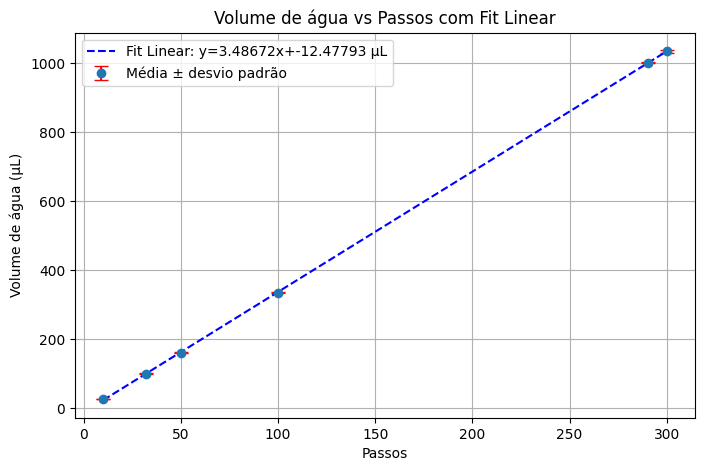

In [15]:
df2=fit_micropipeta(df2)

In [18]:
def ul_to_passos(ul):
    return round((ul+12.47793)/3.48672,1)

ul_to_passos(1000)

290.4

In [6]:
dados_teste = {
    'Peso(g)': [2.1205,2.1665,2.1265,2.1473,2.2201,2.2574],
    'Peso com líquido(g)': [2.421,2.466,2.421,2.444,2.517,2.553],
    'Valor teórico':[300]*6
}

df_teste = pd.DataFrame(dados_teste)

In [12]:
df.tail(18)

,Peso(g),Peso com líquido(g),Passos,Peso água(g),Volume experimental (µL)
78,2.1205,3.118,290.2,0.9975,1000.501505
79,2.1665,3.163,290.2,0.9965,999.498495
80,2.1265,3.128,290.2,1.0015,1004.513541
81,2.1473,3.144,290.2,0.9967,999.699097
82,2.2201,3.216,290.2,0.9959,998.896690
83,2.2574,3.255,290.2,0.9976,1000.601805
84,2.1205,3.122,290.5,1.0015,1004.513541
85,2.1665,3.165,290.5,0.9985,1001.504514
86,2.1265,3.128,290.5,1.0015,1004.513541
87,2.1473,3.150,290.5,1.0027,1005.717151


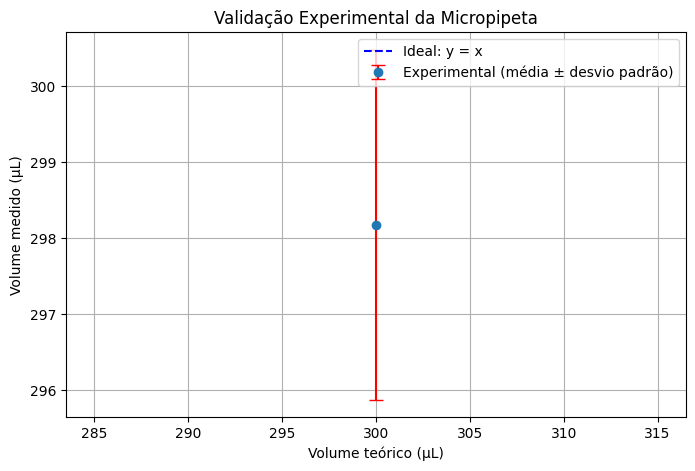


Resumo estatístico por volume teórico:
              Volume experimental (µL)           Erro absoluto (µL)            \
                                  mean       std               mean       std   
Valor teórico                                                                   
300                         298.177867  2.301609          -1.822133  2.301609   

              Erro relativo (%)            
                           mean       std  
Valor teórico                              
300                   -0.607378  0.767203  


In [7]:
resultado_teste = validar_micropipeta(df_teste)


In [8]:
resultado_teste

,Peso(g),Peso com líquido(g),Valor teórico,Peso água(g),Volume experimental (µL),Erro absoluto (µL),Erro relativo (%)
0,2.1205,2.421,300,0.3005,301.404213,1.404213,0.468071
1,2.1665,2.466,300,0.2995,300.401204,0.401204,0.133735
2,2.1265,2.421,300,0.2945,295.386158,-4.613842,-1.537947
3,2.1473,2.444,300,0.2967,297.592778,-2.407222,-0.802407
4,2.2201,2.517,300,0.2969,297.793380,-2.206620,-0.735540
5,2.2574,2.553,300,0.2956,296.489468,-3.510532,-1.170177
